# 1. Установка необходимых библиотек и монтирование Google Drive

In [ ]:
# Монтируем Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Устанавливаем необходимые библиотеки
!pip install bertopic
!pip install prophet
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-c

# 2. Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf
from prophet import Prophet
import xgboost as xgb
from IPython.display import display

# 3. Функция для предобработки и анализа

In [ ]:
def analyze_and_predict_top_topics(df, date_column, topic_column=None, years_ahead=3, label='', model_path=None, years_interval=1, method='linear', exclude_last_year=True):
    if topic_column is None:
        topic_column = 'topic_cluster' if model_path else 'topic'

    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    #Удаляем строки с пустыми или некорректными значениями в date_column и topic_column
    df = df.dropna(subset=[date_column, topic_column])

    # Исключаем строки с пустыми темами (пустая строка или NaN)
    df = df[df[topic_column].astype(str).str.strip () != '']

    # Исключаем шум (тема -1)
    df = df[df[topic_column] != -1]

    df['year'] = df[date_column].dt.year
    df['year_start'] = pd.to_datetime(df['year'].astype(str) + '-01-01')

    if exclude_last_year:
        last_year = df['year'].max()
        df = df[df['year'] < last_year]
        print(f"Исключен неполный год: {last_year}")

    return df

# 4. Функция для создания визуализаций

In [ ]:
# Вспомогательные функции
def auto_arima_like(y,
                    p_range=range(0, 4),
                    d_range=range(0, 2),
                    q_range=range(0, 4),
                    criterion='aic'):
    best_score = float('inf')
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(y, order=(p, d, q)).fit()
            score = getattr(model, criterion)
            if score < best_score:
                best_score = score
                best_order = (p, d, q)
                best_model = model
        except:
            continue

    return best_order, best_model

def manual_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Основная функция обучения и предсказаний
def run_forecast(method, X, y, years_ahead=3, test_size=0.2):
    try:
        split_index = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        if len(y_test) == 0:
            print("Недостаточно данных для разбиения на train/test.")
            return None, None, None, None

        if method == 'linear':
            model = LinearRegression().fit(X_train, y_train)
            pred_test = model.predict(X_test)
            future_pred = model.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'arima':
            best_order, model = auto_arima_like(y_train)
            if model is None or best_order is None:
                print("ARIMA: не удалось подобрать модель")
                return None, None, None, None
            pred_test = model.forecast(steps=len(y_test))
            model_full = ARIMA(y, order=best_order).fit()
            future_pred = model_full.forecast(steps=years_ahead)

        elif method == 'holt':
            model = ExponentialSmoothing(y_train, trend='add').fit()
            pred_test = model.forecast(steps=len(y_test))
            model_full = ExponentialSmoothing(y, trend='add').fit()
            future_pred = model_full.forecast(steps=years_ahead)

        elif method == 'xgboost':
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
            model.fit(X_train, y_train)
            pred_test = model.predict(X_test)
            model_full = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
            model_full.fit(X, y)
            future_pred = model_full.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'random_forest':
            model = RandomForestRegressor(n_estimators=100)
            model.fit(X_train, y_train)
            pred_test = model.predict(X_test)
            model_full = RandomForestRegressor(n_estimators=100)
            model_full.fit(X, y)
            future_pred = model_full.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'lstm':
            scaler = MinMaxScaler()
            y_train_reshaped = y_train.reshape(-1, 1)
            y_scaled = scaler.fit_transform(y_train_reshaped)

            def create_lstm_data(data, step):
                X_l, y_l = [], []
                for i in range(len(data) - step):
                    X_l.append(data[i:i+step, 0])
                    y_l.append(data[i+step, 0])
                return np.array(X_l), np.array(y_l)

            time_step = 3
            X_lstm, y_lstm = create_lstm_data(y_scaled, time_step)
            if len(X_lstm) == 0:
                print("LSTM: недостаточно данных для создания обучающих последовательностей")
                return None, None, None, None
            X_lstm = X_lstm.reshape(X_lstm.shape[0], time_step, 1)

            model = Sequential([
                Input(shape=(time_step, 1)),
                LSTM(50, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')
            dataset = tf.data.Dataset.from_tensor_slices((X_lstm, y_lstm)).batch(16, drop_remainder=True).repeat()
            model.fit(dataset, epochs=20, steps_per_epoch=ceil(len(X_lstm)/16), verbose=0)

            # Подготовка тестовых данных для LSTM
            y_full_scaled = scaler.transform(y.reshape(-1, 1))
            X_test_lstm, y_test_lstm = create_lstm_data(y_full_scaled, time_step)
            if len(X_test_lstm) == 0:
                print("LSTM: недостаточно данных для тестовых последовательностей")
                return None, None, None, None
            X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], time_step, 1)
            pred_scaled = model.predict(X_test_lstm, verbose=0)
            pred_test_full = scaler.inverse_transform(pred_scaled).flatten()

            # Возьмем последние len(y_test) предсказаний для оценки
            pred_test = pred_test_full[-len(y_test):]

            # Прогноз на будущее
            input_seq = y_full_scaled[-time_step:].copy()
            future_pred = []
            for _ in range(years_ahead):
                pred_scaled = model.predict(input_seq.reshape(1, time_step, 1), verbose=0)
                future_pred.append(scaler.inverse_transform(pred_scaled)[0][0])
                input_seq = np.append(input_seq[1:], pred_scaled)

        elif method == 'prophet':
            # Для Prophet нужен DataFrame с колонками ds (даты) и y (значения)
            # Используем реальные года в формате datetime
            ds_train = pd.to_datetime(X_train.flatten() + 2000, format='%Y')
            prophet_df = pd.DataFrame({'ds': ds_train, 'y': y_train})
            model = Prophet(yearly_seasonality=True, n_changepoints=3)
            model.fit(prophet_df)

            ds_test = pd.to_datetime(X_test.flatten() + 2000, format='%Y')
            future = pd.DataFrame({'ds': ds_test})
            forecast = model.predict(future)
            pred_test = forecast['yhat'].values

            # Для полного прогноза по всем данным
            ds_full = pd.to_datetime(X.flatten() + 2000, format='%Y')
            model_full = Prophet(yearly_seasonality=True, n_changepoints=3)
            model_full.fit(pd.DataFrame({'ds': ds_full, 'y': y}))
            future_full = model_full.make_future_dataframe(periods=years_ahead, freq='Y')
            forecast_full = model_full.predict(future_full)
            future_pred = forecast_full['yhat'][-years_ahead:].values

        else:
            print(f"Метод {method} не реализован.")
            return None, None, None, None

        rmse_val = manual_rmse(y_test, pred_test)
        mape_val = safe_mape(y_test, pred_test)

        return rmse_val, mape_val, np.concatenate([y_train, pred_test]), future_pred

    except Exception as e:
        print(f"Ошибка в методе {method}: {e}")
        return None, None, None, None

In [ ]:
def plot_topic_trends(df, topic_column, years_ahead=3, label='', save_dir=None):
    years_to_show = 10
    topic_counts = df[topic_column].value_counts().head(5).index.tolist()
    df = df[df[topic_column].isin(topic_counts)]

    topic_by_year_full = df.groupby(['year_start', topic_column]).size().unstack(fill_value=0).sort_index()

    year_ints_full = pd.to_datetime(topic_by_year_full.index).year.tolist()
    year_indices_full = np.arange(len(year_ints_full))

    source_palettes = {
        "VK": sns.color_palette("Set1", len(topic_by_year_full.columns)),
        "GNews": sns.color_palette("Paired", len(topic_by_year_full.columns)),
        "CyberLeninka": sns.color_palette("husl", len(topic_by_year_full.columns))
    }
    plt.figure(figsize=(14, 6))
    color_palette = source_palettes.get(label, sns.color_palette("hls", len(topic_by_year_full.columns)))

    best_methods = {}
    all_results = {}

    for idx, topic in enumerate(topic_by_year_full.columns):
        y_full = topic_by_year_full[topic].values
        if len(y_full) < 2 or np.all(y_full == 0):
            print(f"Пропуск темы {topic}: недостаточно данных")
            continue

        X_full = year_indices_full.reshape(-1, 1)
        best_rmse = float('inf')
        best_method = None
        best_pred = None
        best_future = None
        best_mape = None

        for m in ['linear', 'arima', 'holt', 'xgboost', 'random_forest', 'lstm', 'prophet']:
            rmse, mape, pred, future_pred = run_forecast(m, X_full, y_full)
            if pred is None:
                print(f"Пропуск метода {m} для темы {topic}: нет предсказаний")
                continue
            if rmse is not None:
                all_results.setdefault('Тема', []).append(topic)
                all_results.setdefault('Метод', []).append(m)
                all_results.setdefault('RMSE', []).append(round(rmse, 2))
                all_results.setdefault('MAPE', []).append(round(mape * 100, 2))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_method = m
                    best_pred = pred
                    best_future = future_pred
                    best_mape = mape

        if best_method is not None:
            best_methods[topic] = {
                'method': best_method,
                'pred': best_pred,
                'future': best_future,
                'rmse': best_rmse,
                'mape': best_mape,
                'y': y_full
            }

    start_year = 2000
    available_years = pd.to_datetime(topic_by_year_full.index).year.tolist()
    first_year = min(available_years)
    plot_start_year = start_year if first_year <= start_year else first_year

    filtered_years = [y for y in available_years if y >= plot_start_year]
    filtered_indices = [available_years.index(y) for y in filtered_years]

    for idx, topic in enumerate(best_methods.keys()):
        data = best_methods[topic]
        color = color_palette[idx]

        y = data['y']
        pred = data['pred']
        future = data['future']

        y_plot = y[filtered_indices]
        pred_plot = pred[filtered_indices]

        # Исторические данные — сплошная линия до 2024 включительно
        years_until_2024 = [y for y in filtered_years if y <= 2024]
        indices_until_2024 = [filtered_years.index(y) for y in years_until_2024]
        y_until_2024 = y_plot[indices_until_2024]

        plt.plot(years_until_2024, y_until_2024, label=f'Тема {topic} ({data["method"]})', linewidth=2, color=color)

        # Пунктирная линия между 2024 и 2025 — отдельная "связка"
        if 2024 in filtered_years:
            idx_2024 = filtered_years.index(2024)
            val_2024 = y_plot[idx_2024]
            val_2025 = future[0]  # первый год прогноза - 2025
            plt.plot([2024, 2025], [val_2024, val_2025], '--', alpha=0.7, color=color)

        # Пунктирная линия прогноза начиная с 2025 и дальше
        future_years = [2025 + i for i in range(years_ahead)]
        plt.plot(future_years, future, '--', alpha=0.7, color=color)

    plt.title(f'Тренды топ-5 тем ({label})')
    plt.xlabel('Год')
    plt.ylabel('Число документов')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)

    if all_results:
        df_results = pd.DataFrame(all_results)
        print("\nСравнение моделей по метрикам (RMSE и MAPE):")
        display(df_results.pivot(index='Тема', columns='Метод', values='RMSE').round(2))
        display(df_results.pivot(index='Тема', columns='Метод', values='MAPE').round(2))

        best_models = df_results.loc[df_results.groupby('Тема')['RMSE'].idxmin()].reset_index(drop=True)
        best_models.rename(columns={'Метод': 'Лучшая модель', 'RMSE': 'Лучший RMSE', 'MAPE': 'Лучший MAPE (%)'}, inplace=True)
        print("\nИтоговая таблица лучших моделей по RMSE для каждой темы:")
        display(best_models)
    else:
        print("Нет данных для сравнения моделей.")
        best_models = pd.DataFrame()

    if save_dir is not None and not best_models.empty:
        save_path = os.path.join(save_dir, f"{label}_topic_trends_forecasting.png")
        plt.savefig(save_path)
        print(f"График сохранен: {save_path}")

    plt.show()

    return best_models

# 5. Запуск анализа для различных источников данных


**RMSE** (Root Mean Squared Error, Среднеквадратическая ошибка) показывает абсолютную ошибку в исходных единицах.

**MAPE** (Mean Absolute Percentage Error, Средняя абсолютная процентная ошибка) - относительную ошибку в % (проще для интерпретации "на глаз").

`Чем меньше значения, тем лучше.`


Анализ: VK
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/p

LSTM: недостаточно данных для создания обучающих последовательностей
Пропуск метода lstm для темы 0: нет предсказаний


14:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

LSTM: недостаточно данных для создания обучающих последовательностей
Пропуск метода lstm для темы 2: нет предсказаний


14:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

LSTM: недостаточно данных для создания обучающих последовательностей
Пропуск метода lstm для темы 3: нет предсказаний


INFO:cmdstanpy:Chain [1] start processing
14:09:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Us

LSTM: недостаточно данных для создания обучающих последовательностей
Пропуск метода lstm для темы 4: нет предсказаний


14:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

LSTM: недостаточно данных для создания обучающих последовательностей
Пропуск метода lstm для темы 6: нет предсказаний


14:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



Сравнение моделей по метрикам (RMSE и MAPE):


Метод,arima,holt,linear,prophet,random_forest,xgboost
Тема,,,,,,
0,1083.0,588.0,588.0,581.40,997.20,918.0
2,17.0,1.0,1.0,3.15,11.16,9.0
3,20.0,8.0,8.0,10.57,14.96,14.0
4,15.0,9.0,9.0,9.81,12.90,12.0
6,19.0,1.0,1.0,3.42,11.98,10.0


Метод,arima,holt,linear,prophet,random_forest,xgboost
Тема,,,,,,
0,76.97,41.79,41.79,41.32,70.87,65.25
2,100.00,5.89,5.88,18.54,65.65,52.95
3,83.33,33.33,33.33,44.02,62.33,58.34
4,100.00,60.00,60.00,65.38,86.00,80.01
6,100.00,5.26,5.26,18.00,63.05,52.64



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,prophet,581.4,41.32
1,2,linear,1.0,5.88
2,3,linear,8.0,33.33
3,4,linear,9.0,60.00
4,6,linear,1.0,5.26


График сохранён: /content/drive/MyDrive/TextScope/plots/VK_topic_trends_forecasting.png


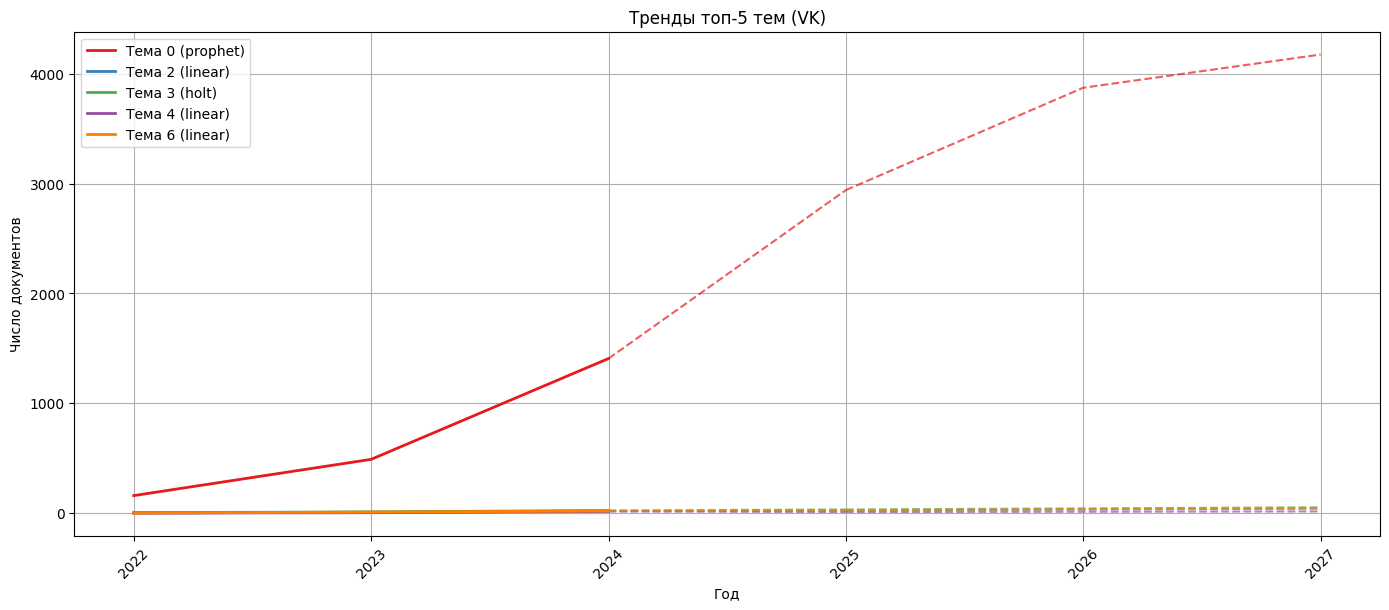


Анализ: GNews
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver


Сравнение моделей по метрикам (RMSE и MAPE):


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,68.30,64.65,70.12,67.57,70.15,66.95,65.04
1,25.35,25.05,26.78,25.64,26.76,25.61,25.35
2,14.69,13.51,15.27,14.72,15.31,14.33,13.59
3,4.73,4.68,5.10,5.27,5.07,4.45,4.22
4,8.06,7.28,7.28,7.81,7.24,8.27,8.37


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,80.66,70.64,86.61,87.97,86.72,70.28,60.94
1,76.19,74.99,93.91,91.26,93.78,79.28,76.20
2,89.74,77.97,94.16,92.37,93.79,82.08,72.44
3,76.78,65.24,85.25,94.68,85.96,54.78,48.23
4,92.31,73.95,73.95,88.46,74.48,97.63,99.99



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,holt,64.65,70.64
1,1,holt,25.05,74.99
2,2,holt,13.51,77.97
3,3,xgboost,4.22,48.23
4,4,prophet,7.24,74.48


График сохранён: /content/drive/MyDrive/TextScope/plots/GNews_topic_trends_forecasting.png


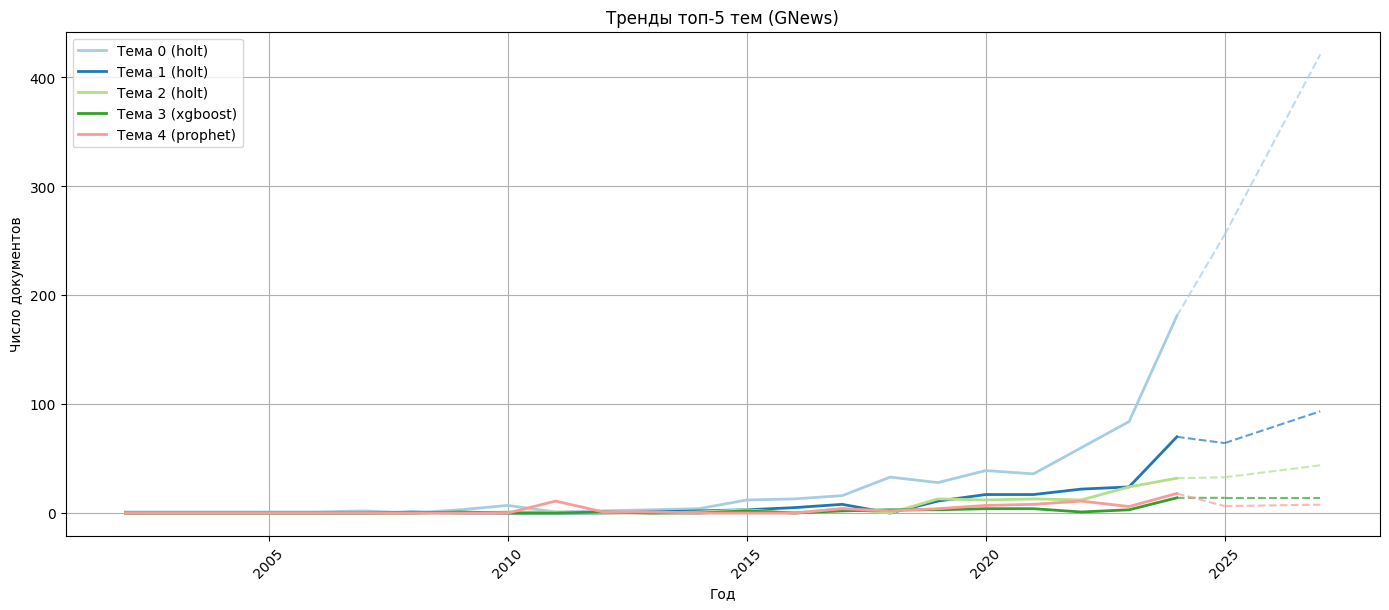


Анализ: CyberLeninka
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver


Сравнение моделей по метрикам (RMSE и MAPE):


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,41.23,42.92,158.32,152.06,158.31,128.36,122.66
2,89.52,60.66,158.40,179.15,158.46,120.10,109.71
3,99.29,36.84,128.60,121.84,128.62,97.47,93.38
4,90.13,96.83,171.11,192.76,171.11,147.66,145.78
6,57.01,42.38,179.30,208.71,179.29,150.33,142.49


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,18.24,22.51,90.92,88.25,90.94,70.20,66.27
2,41.80,24.42,89.90,103.36,89.93,60.62,54.87
3,62.96,20.16,88.02,85.24,88.03,61.29,57.77
4,44.36,46.49,91.44,104.92,91.46,71.73,70.18
6,26.77,19.15,91.38,107.17,91.41,72.50,67.44



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,arima,41.23,18.24
1,2,holt,60.66,24.42
2,3,holt,36.84,20.16
3,4,arima,90.13,44.36
4,6,holt,42.38,19.15


График сохранён: /content/drive/MyDrive/TextScope/plots/CyberLeninka_topic_trends_forecasting.png


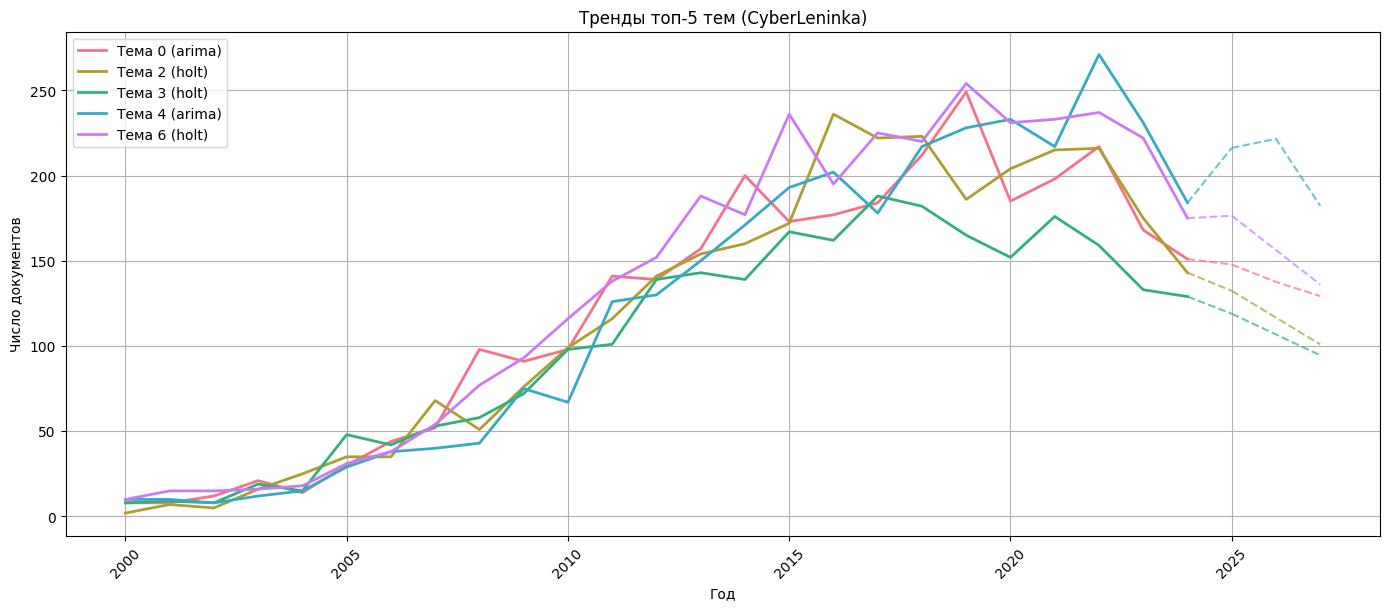

In [ ]:
# Пути к данным и моделям
sources = {
    "VK": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_vk_data_topics.csv",
        "model_path": "/content/drive/MyDrive/TextScope/processed_vk_data_topics_bertopic_model"
    },
    "GNews": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_gnews_data_topics.csv",
        "model_path": "/content/drive/MyDrive/TextScope/processed_gnews_data_topics_bertopic_model"
    },
    "CyberLeninka": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_cyberleninka_data_keywords_topics.csv",
        "model_path": None  # LDA — нет BERTopic модели
    }
}

plots_dir = "/content/drive/MyDrive/TextScope/plots"
os.makedirs(plots_dir, exist_ok=True)

for label, paths in sources.items():
    path = paths['data_path']
    model_path = paths['model_path']

    if not os.path.exists(path):
        print(f"Файл не найден: {path} — пропускаем.")
        continue

    print(f"\nАнализ: {label}")
    df = pd.read_csv(path)

    # Определение названия колонки с датой
    date_col = 'date' if 'date' in df.columns else 'published_at' if 'published_at' in df.columns else None
    if date_col is None:
        print(f"Нет колонки с датой в {label} — пропуск.")
        continue

    df_prepared = analyze_and_predict_top_topics(
        df,
        date_column=date_col,
        topic_column='topic',
        label=label,
        model_path=model_path,
        exclude_last_year=True
    )

    plot_topic_trends(
        df_prepared,
        topic_column='topic',
        years_ahead=3,
        label=label,
        save_dir=plots_dir
    )